In [36]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

from os.path import join

plt.style.use(["seaborn", "thesis"])

In [37]:
plt.rc("figure", figsize=(8,4))

# Fetch Dataset 

In [3]:
from SCFInitialGuess.utilities.dataset import ScreenedData

target = "P"

data = ScreenedData(r_max=10)

data.include(data_path = "../../dataset/MethanT/", postfix = "MethanT", target=target)
data.include(data_path = "../../dataset/MethanT2/", postfix = "MethanT2", target=target)
data.include(data_path = "../../dataset/MethanT3/", postfix = "MethanT3", target=target)
data.include(data_path = "../../dataset/MethanT4/", postfix = "MethanT4", target=target)

data.include(data_path = "../../dataset/EthanT/",  postfix = "EthanT", target=target)
data.include(data_path = "../../dataset/EthanT2/", postfix = "EthanT2", target=target)
data.include(data_path = "../../dataset/EthanT3/", postfix = "EthanT3", target=target)
data.include(data_path = "../../dataset/EthanT4/",  postfix = "EthanT4", target=target)
data.include(data_path = "../../dataset/EthanT5/",  postfix = "EthanT5", target=target)
data.include(data_path = "../../dataset/EthanT6/",  postfix = "EthanT6", target=target)

data.include(data_path = "../../dataset/EthenT/",  postfix = "EthenT", target=target)
data.include(data_path = "../../dataset/EthenT2/", postfix = "EthenT2", target=target)
data.include(data_path = "../../dataset/EthenT3/", postfix = "EthenT3", target=target)
data.include(data_path = "../../dataset/EthenT4/",  postfix = "EthenT4", target=target)
data.include(data_path = "../../dataset/EthenT5/",  postfix = "EthenT5", target=target)
data.include(data_path = "../../dataset/EthenT6/",  postfix = "EthenT6", target=target)


data.include(data_path = "../../dataset/EthinT/",  postfix = "EthinT", target=target)
data.include(data_path = "../../dataset/EthinT2/", postfix = "EthinT2", target=target)
data.include(data_path = "../../dataset/EthinT3/", postfix = "EthinT3", target=target)

#data.include(data_path = "../../dataset/QM9/", postfix = "QM9-300")

# SetUp descriptor And Normalisation

## Center

In [4]:
import pickle

model_path_center = "../../models/Descriptor"
target = "P"

descriptor_C = pickle.load(open(model_path_center + "C/" + target + "/descriptor.dump", "rb"))
descriptor_H = pickle.load(open(model_path_center + "H/" + target + "/descriptor.dump", "rb"))

descriptors_center = {
    "C": descriptor_C,
    "H": descriptor_H
}

In [5]:
descriptor_H

In [6]:
normalisations_center = {
    "C": np.load(model_path_center + "C/" + target + "/normalisation.npy"),
    "H": np.load(model_path_center + "H/" + target + "/normalisation.npy")
}

In [7]:
name_C = model_path_center + "C/" + target + "/C_" + target + ".h5"
name_H = model_path_center + "H/" + target + "/H_" + target + ".h5"


model_C = keras.models.load_model(name_C)
model_H = keras.models.load_model(name_H)

networks_center = {
    "C": model_C,
    "H": model_H
}

## Homo  

In [8]:
import pickle

model_path_homo = "../../models/DescriptorHomo"
target = "P"

descriptor_CC = pickle.load(open(model_path_homo + "/CC/descriptor.dump", "rb"))
descriptor_HH = pickle.load(open(model_path_homo + "/HH/descriptor.dump", "rb"))

descriptors_homo = {
    "C": descriptor_C,
    "H": descriptor_H
}

In [9]:
normalisations_homo = {
    "C": np.load(model_path_homo + "/CC/normalisation.npy"),
    "H": np.load(model_path_homo + "/HH/normalisation.npy")
}

In [10]:
name_C = model_path_homo + "/CC/model.h5"
name_H = model_path_homo + "/HH/model.h5"


model_C = keras.models.load_model(name_C)
model_H = keras.models.load_model(name_H)

networks_homo = {
    "C": model_C,
    "H": model_H
}

## Hetero 

In [11]:
import pickle

model_path_hetero = "../../models/DescriptorHetero"
target = "P"

descriptor_C = pickle.load(open(model_path_hetero + "/CH/descriptor_C.dump", "rb"))
descriptor_H = pickle.load(open(model_path_hetero + "/CH/descriptor_H.dump", "rb"))

descriptors_hetero = {
    frozenset(["H","C"]): (descriptor_C, descriptor_H),
}

In [12]:
normalisations_hetero = {
    frozenset(["H","C"]): np.load(model_path_hetero + "/CH/normalisation.npy"),
}

In [13]:
name_CH = model_path_hetero + "/CH/model.h5"



model_CH = keras.models.load_model(name_CH)


networks_hetero = {
    frozenset(["H","C"]): model_CH,
}

# Guess Method 

In [14]:
def estimate_center_block(mol, atom_index, atom):
    """Estimates center block of the density matrix.
    Returns mask and flattened block."""
    
    mask = mol.make_atom_mask(atom_index)
        
        
    G = descriptors_center[atom].calculate_atom_descriptor(
        atom_index, 
        mol,
        descriptors_center[atom].number_of_descriptors
    )

    G_norm = AbstractDataset.normalize(G, *normalisations_center[atom])

    #f(G)
    f = networks_center[atom].predict(G.reshape(1, -1))

    f_batch = reconstruct_from_triu(
        f,
        N_BASIS[mol.basis][atom]
    )
    
    return mask, f_batch.flatten()

In [15]:
def estimate_homo_block(mol, i, j, atom):
    """Estimates homo block of the density matrix.
    Returns mask and flattened block.
    """
    from SCFInitialGuess.construction.utilities import \
        make_atom_pair_mask
  
    mask = make_atom_pair_mask(mol, i, j)
        
        
    G = np.array(
        list(
            descriptors_homo[atom].calculate_atom_descriptor(
                i, 
                mol,
                descriptors_homo[atom].number_of_descriptors
            )
        ) + list(
            descriptors_homo[atom].calculate_atom_descriptor(
                j, 
                mol,
                descriptors_homo[atom].number_of_descriptors
            )
        )
    )
    
    G_norm = AbstractDataset.normalize(G, *normalisations_homo[atom])

    #f(G)
    f = networks_homo[atom].predict(G.reshape(1, -1))
    
    return mask, f.flatten()

In [16]:
def estimate_hetero_block(mol, i, atom_i, j, atom_j):
    """Estimates homo block of the density matrix.
    Returns mask and flattened block.
    
    TODO: C-H combination is hardcoded. make more flexible
    """
    from SCFInitialGuess.construction.utilities import \
        make_atom_pair_mask
        
    mask = make_atom_pair_mask(mol, i, j)
        
    if atom_i == "C":
        ii = i
        jj = j
    else:
        ii = j
        jj = i
        
    descriptor_C = descriptors_hetero[frozenset(["C", "H"])][0]
    descriptor_H = descriptors_hetero[frozenset(["C", "H"])][1]
        
        
    G = np.array(
        list(
            descriptor_C.calculate_atom_descriptor(
                ii, 
                mol,
                descriptor_C.number_of_descriptors
            )
        ) + list(
            descriptor_H.calculate_atom_descriptor(
                jj, 
                mol,
                descriptor_H.number_of_descriptors
            )
        )
    )
    
    G_norm = AbstractDataset.normalize(G, *normalisations_hetero[frozenset(["H","C"])])

    #f(G)
    f = networks_hetero[frozenset(["H","C"])].predict(G.reshape(1, -1))
    
    return mask, f.flatten()

In [17]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu, AbstractDataset
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS
from pyscf.scf import hf
from SCFInitialGuess.utilities.dataset import density_from_fock, fock_from_density

def init_guess_by_full_sannd(mol):
    
    mole = mol.get_pyscf_molecule()
    
    p  = hf.init_guess_by_wolfsberg_helmholtz(mole).copy() # TODO set up my own GWH in SCFInitialGuess
    p0 = p.copy()
    
    for i, atom_i in enumerate(mol.species):
        for j, atom_j in enumerate(mol.species):
            
            # only lower half
            if i < j:
                continue
            
            # center
            if i==j:
                mask, p_guess = estimate_center_block(mol, i, atom_i)
                p[mask] = p_guess
            """    
            # homo
            elif atom_i == atom_j and i != j:
                mask, p_guess = estimate_homo_block(mol, i, j, atom_i)
                p[mask] = p_guess
            
            # hetero
            else:
                mask, p_guess = estimate_hetero_block(mol, i, atom_i, j, atom_j)
                p[mask] = p_guess
            """    
                
    # reconstruct upper triu
    p = np.tril(p) + np.tril(p, -1).transpose()
    
    h = hf.get_hcore(mole)
    s = hf.get_ovlp(mole)
        
    # add iteration
    p = density_from_fock(fock_from_density(p, s, h, mole), s, mole)
        
    return p
        
    

# Analysis 

## Utils 

In [18]:
from SCFInitialGuess.utilities.dataset import StaticDataset

dataset = StaticDataset(
    #train=(s_train, p_train),
    train=(data.S[0], data.T[0]),
    validation=(data.S[1], data.T[1]),
    test=(data.S[2], data.T[2]),
    mu=0,
    std=1
)

 ## Execution 

In [19]:
p = init_guess_by_full_sannd(data.molecules[2][0])

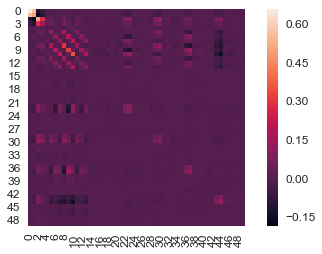

In [20]:
sns.heatmap(init_guess_by_full_sannd(data.molecules[2][0]), square=True)

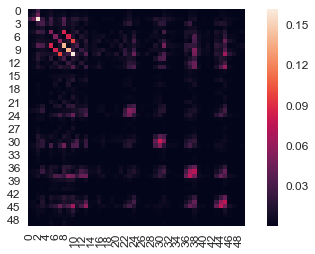

In [38]:
sns.heatmap(
    np.abs(
        init_guess_by_full_sannd(
            data.molecules[2][0]
        ) - data.T[2][0]
    ), 
    square=True
)

In [22]:
p_nn = np.array([
    init_guess_by_full_sannd(mol) for mol in data.molecules[2]
])

In [23]:
np.save("data/p_nn_full_sannd.npy", p_nn)

In [24]:
p_nn = np.load("data/p_nn_full_sannd.npy")

# Scatter 

In [25]:
plt.rc("figure", figsize=(6,5))

In [26]:
def flatten(x):
    y = []
    for xi in x:
        y += list(xi.flatten())
    return y

p_exp = flatten(data.T[2])
p_nn_flatten = flatten(p_nn)

In [27]:
ind = np.arange(len(p_exp))
np.random.shuffle(ind)
print(len(p_exp), len(p_nn_flatten))

10259432 10259432


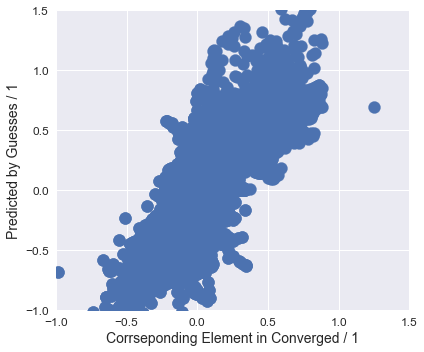

In [28]:
n_max = len(p_exp)
plt.scatter(
    np.array(p_exp),#[ind[:n_max]], 
    np.array(p_nn_flatten),#[ind[:n_max]]
)

plt.xlim(-1, 1.5)
plt.ylim(-1, 1.5)

plt.xlabel("Corrseponding Element in Converged / 1")
plt.ylabel("Predicted by Guesses / 1")

plt.tight_layout()

plt.show()

# Properties 

In [29]:
from SCFInitialGuess.utilities.analysis import analyze_raw_batch, format_raw

from SCFInitialGuess.utilities.analysis import analyze_raw_batch
result = analyze_raw_batch(
    p_nn,
    data.T[2],
    data.S[2],
    data.molecules[2]
)

[ ] 2019-02-11 22:50:36: 1 / 2225
[ ] 2019-02-11 22:50:37: 2 / 2225
[ ] 2019-02-11 22:50:37: 3 / 2225
[ ] 2019-02-11 22:50:38: 4 / 2225
[ ] 2019-02-11 22:50:38: 5 / 2225
[ ] 2019-02-11 22:50:39: 6 / 2225
[ ] 2019-02-11 22:50:39: 7 / 2225
[ ] 2019-02-11 22:50:40: 8 / 2225
[ ] 2019-02-11 22:50:41: 9 / 2225
[ ] 2019-02-11 22:50:41: 10 / 2225
[ ] 2019-02-11 22:50:42: 11 / 2225
[ ] 2019-02-11 22:50:42: 12 / 2225
[ ] 2019-02-11 22:50:43: 13 / 2225
[ ] 2019-02-11 22:50:43: 14 / 2225
[ ] 2019-02-11 22:50:44: 15 / 2225
[ ] 2019-02-11 22:50:44: 16 / 2225
[ ] 2019-02-11 22:50:45: 17 / 2225
[ ] 2019-02-11 22:50:46: 18 / 2225
[ ] 2019-02-11 22:50:46: 19 / 2225
[ ] 2019-02-11 22:50:47: 20 / 2225
[ ] 2019-02-11 22:50:47: 21 / 2225
[ ] 2019-02-11 22:50:48: 22 / 2225
[ ] 2019-02-11 22:50:48: 23 / 2225
[ ] 2019-02-11 22:50:49: 24 / 2225
[ ] 2019-02-11 22:50:49: 25 / 2225
[ ] 2019-02-11 22:50:50: 26 / 2225
[ ] 2019-02-11 22:50:50: 27 / 2225
[ ] 2019-02-11 22:50:51: 28 / 2225
[ ] 2019-02-11 22:50:52: 29 /

[ ] 2019-02-11 22:53:00: 232 / 2225
[ ] 2019-02-11 22:53:01: 233 / 2225
[ ] 2019-02-11 22:53:02: 234 / 2225
[ ] 2019-02-11 22:53:04: 235 / 2225
[ ] 2019-02-11 22:53:05: 236 / 2225
[ ] 2019-02-11 22:53:06: 237 / 2225
[ ] 2019-02-11 22:53:07: 238 / 2225
[ ] 2019-02-11 22:53:08: 239 / 2225
[ ] 2019-02-11 22:53:10: 240 / 2225
[ ] 2019-02-11 22:53:11: 241 / 2225
[ ] 2019-02-11 22:53:11: 242 / 2225
[ ] 2019-02-11 22:53:12: 243 / 2225
[ ] 2019-02-11 22:53:13: 244 / 2225
[ ] 2019-02-11 22:53:14: 245 / 2225
[ ] 2019-02-11 22:53:15: 246 / 2225
[ ] 2019-02-11 22:53:16: 247 / 2225
[ ] 2019-02-11 22:53:17: 248 / 2225
[ ] 2019-02-11 22:53:18: 249 / 2225
[ ] 2019-02-11 22:53:19: 250 / 2225
[ ] 2019-02-11 22:53:20: 251 / 2225
[ ] 2019-02-11 22:53:21: 252 / 2225
[ ] 2019-02-11 22:53:22: 253 / 2225
[ ] 2019-02-11 22:53:23: 254 / 2225
[ ] 2019-02-11 22:53:25: 255 / 2225
[ ] 2019-02-11 22:53:26: 256 / 2225
[ ] 2019-02-11 22:53:27: 257 / 2225
[ ] 2019-02-11 22:53:28: 258 / 2225
[ ] 2019-02-11 22:53:30: 259

[ ] 2019-02-11 22:56:20: 460 / 2225
[ ] 2019-02-11 22:56:21: 461 / 2225
[ ] 2019-02-11 22:56:22: 462 / 2225
[ ] 2019-02-11 22:56:22: 463 / 2225
[ ] 2019-02-11 22:56:23: 464 / 2225
[ ] 2019-02-11 22:56:24: 465 / 2225
[ ] 2019-02-11 22:56:24: 466 / 2225
[ ] 2019-02-11 22:56:25: 467 / 2225
[ ] 2019-02-11 22:56:26: 468 / 2225
[ ] 2019-02-11 22:56:26: 469 / 2225
[ ] 2019-02-11 22:56:27: 470 / 2225
[ ] 2019-02-11 22:56:27: 471 / 2225
[ ] 2019-02-11 22:56:28: 472 / 2225
[ ] 2019-02-11 22:56:29: 473 / 2225
[ ] 2019-02-11 22:56:29: 474 / 2225
[ ] 2019-02-11 22:56:30: 475 / 2225
[ ] 2019-02-11 22:56:30: 476 / 2225
[ ] 2019-02-11 22:56:31: 477 / 2225
[ ] 2019-02-11 22:56:31: 478 / 2225
[ ] 2019-02-11 22:56:32: 479 / 2225
[ ] 2019-02-11 22:56:32: 480 / 2225
[ ] 2019-02-11 22:56:33: 481 / 2225
[ ] 2019-02-11 22:56:33: 482 / 2225
[ ] 2019-02-11 22:56:34: 483 / 2225
[ ] 2019-02-11 22:56:34: 484 / 2225
[ ] 2019-02-11 22:56:35: 485 / 2225
[ ] 2019-02-11 22:56:36: 486 / 2225
[ ] 2019-02-11 22:56:36: 487

[ ] 2019-02-11 23:01:16: 688 / 2225
[ ] 2019-02-11 23:01:17: 689 / 2225
[ ] 2019-02-11 23:01:19: 690 / 2225
[ ] 2019-02-11 23:01:20: 691 / 2225
[ ] 2019-02-11 23:01:21: 692 / 2225
[ ] 2019-02-11 23:01:22: 693 / 2225
[ ] 2019-02-11 23:01:23: 694 / 2225
[ ] 2019-02-11 23:01:25: 695 / 2225
[ ] 2019-02-11 23:01:26: 696 / 2225
[ ] 2019-02-11 23:01:27: 697 / 2225
[ ] 2019-02-11 23:01:28: 698 / 2225
[ ] 2019-02-11 23:01:29: 699 / 2225
[ ] 2019-02-11 23:01:31: 700 / 2225
[ ] 2019-02-11 23:01:32: 701 / 2225
[ ] 2019-02-11 23:01:33: 702 / 2225
[ ] 2019-02-11 23:01:35: 703 / 2225
[ ] 2019-02-11 23:01:36: 704 / 2225
[ ] 2019-02-11 23:01:37: 705 / 2225
[ ] 2019-02-11 23:01:38: 706 / 2225
[ ] 2019-02-11 23:01:39: 707 / 2225
[ ] 2019-02-11 23:01:41: 708 / 2225
[ ] 2019-02-11 23:01:42: 709 / 2225
[ ] 2019-02-11 23:01:43: 710 / 2225
[ ] 2019-02-11 23:01:44: 711 / 2225
[ ] 2019-02-11 23:01:45: 712 / 2225
[ ] 2019-02-11 23:01:46: 713 / 2225
[ ] 2019-02-11 23:01:47: 714 / 2225
[ ] 2019-02-11 23:01:48: 715

[ ] 2019-02-11 23:04:56: 916 / 2225
[ ] 2019-02-11 23:04:57: 917 / 2225
[ ] 2019-02-11 23:04:58: 918 / 2225
[ ] 2019-02-11 23:04:59: 919 / 2225
[ ] 2019-02-11 23:05:00: 920 / 2225
[ ] 2019-02-11 23:05:00: 921 / 2225
[ ] 2019-02-11 23:05:01: 922 / 2225
[ ] 2019-02-11 23:05:02: 923 / 2225
[ ] 2019-02-11 23:05:03: 924 / 2225
[ ] 2019-02-11 23:05:04: 925 / 2225
[ ] 2019-02-11 23:05:06: 926 / 2225
[ ] 2019-02-11 23:05:08: 927 / 2225
[ ] 2019-02-11 23:05:10: 928 / 2225
[ ] 2019-02-11 23:05:11: 929 / 2225
[ ] 2019-02-11 23:05:13: 930 / 2225
[ ] 2019-02-11 23:05:14: 931 / 2225
[ ] 2019-02-11 23:05:15: 932 / 2225
[ ] 2019-02-11 23:05:16: 933 / 2225
[ ] 2019-02-11 23:05:17: 934 / 2225
[ ] 2019-02-11 23:05:18: 935 / 2225
[ ] 2019-02-11 23:05:19: 936 / 2225
[ ] 2019-02-11 23:05:20: 937 / 2225
[ ] 2019-02-11 23:05:21: 938 / 2225
[ ] 2019-02-11 23:05:22: 939 / 2225
[ ] 2019-02-11 23:05:23: 940 / 2225
[ ] 2019-02-11 23:05:24: 941 / 2225
[ ] 2019-02-11 23:05:25: 942 / 2225
[ ] 2019-02-11 23:05:26: 943

[ ] 2019-02-11 23:08:20: 1140 / 2225
[ ] 2019-02-11 23:08:20: 1141 / 2225
[ ] 2019-02-11 23:08:21: 1142 / 2225
[ ] 2019-02-11 23:08:22: 1143 / 2225
[ ] 2019-02-11 23:08:23: 1144 / 2225
[ ] 2019-02-11 23:08:24: 1145 / 2225
[ ] 2019-02-11 23:08:25: 1146 / 2225
[ ] 2019-02-11 23:08:26: 1147 / 2225
[ ] 2019-02-11 23:08:26: 1148 / 2225
[ ] 2019-02-11 23:08:27: 1149 / 2225
[ ] 2019-02-11 23:08:28: 1150 / 2225
[ ] 2019-02-11 23:08:29: 1151 / 2225
[ ] 2019-02-11 23:08:30: 1152 / 2225
[ ] 2019-02-11 23:08:31: 1153 / 2225
[ ] 2019-02-11 23:08:31: 1154 / 2225
[ ] 2019-02-11 23:08:32: 1155 / 2225
[ ] 2019-02-11 23:08:33: 1156 / 2225
[ ] 2019-02-11 23:08:34: 1157 / 2225
[ ] 2019-02-11 23:08:35: 1158 / 2225
[ ] 2019-02-11 23:08:36: 1159 / 2225
[ ] 2019-02-11 23:08:36: 1160 / 2225
[ ] 2019-02-11 23:08:37: 1161 / 2225
[ ] 2019-02-11 23:08:38: 1162 / 2225
[ ] 2019-02-11 23:08:39: 1163 / 2225
[ ] 2019-02-11 23:08:40: 1164 / 2225
[ ] 2019-02-11 23:08:41: 1165 / 2225
[ ] 2019-02-11 23:08:42: 1166 / 2225
[

[ ] 2019-02-11 23:11:16: 1362 / 2225
[ ] 2019-02-11 23:11:17: 1363 / 2225
[ ] 2019-02-11 23:11:18: 1364 / 2225
[ ] 2019-02-11 23:11:18: 1365 / 2225
[ ] 2019-02-11 23:11:19: 1366 / 2225
[ ] 2019-02-11 23:11:20: 1367 / 2225
[ ] 2019-02-11 23:11:20: 1368 / 2225
[ ] 2019-02-11 23:11:21: 1369 / 2225
[ ] 2019-02-11 23:11:22: 1370 / 2225
[ ] 2019-02-11 23:11:23: 1371 / 2225
[ ] 2019-02-11 23:11:24: 1372 / 2225
[ ] 2019-02-11 23:11:25: 1373 / 2225
[ ] 2019-02-11 23:11:26: 1374 / 2225
[ ] 2019-02-11 23:11:26: 1375 / 2225
[ ] 2019-02-11 23:11:27: 1376 / 2225
[ ] 2019-02-11 23:11:28: 1377 / 2225
[ ] 2019-02-11 23:11:29: 1378 / 2225
[ ] 2019-02-11 23:11:29: 1379 / 2225
[ ] 2019-02-11 23:11:30: 1380 / 2225
[ ] 2019-02-11 23:11:31: 1381 / 2225
[ ] 2019-02-11 23:11:31: 1382 / 2225
[ ] 2019-02-11 23:11:32: 1383 / 2225
[ ] 2019-02-11 23:11:33: 1384 / 2225
[ ] 2019-02-11 23:11:33: 1385 / 2225
[ ] 2019-02-11 23:11:34: 1386 / 2225
[ ] 2019-02-11 23:11:35: 1387 / 2225
[ ] 2019-02-11 23:11:36: 1388 / 2225
[

[ ] 2019-02-11 23:13:57: 1584 / 2225
[ ] 2019-02-11 23:13:58: 1585 / 2225
[ ] 2019-02-11 23:13:58: 1586 / 2225
[ ] 2019-02-11 23:13:59: 1587 / 2225
[ ] 2019-02-11 23:14:00: 1588 / 2225
[ ] 2019-02-11 23:14:01: 1589 / 2225
[ ] 2019-02-11 23:14:02: 1590 / 2225
[ ] 2019-02-11 23:14:02: 1591 / 2225
[ ] 2019-02-11 23:14:03: 1592 / 2225
[ ] 2019-02-11 23:14:04: 1593 / 2225
[ ] 2019-02-11 23:14:04: 1594 / 2225
[ ] 2019-02-11 23:14:05: 1595 / 2225
[ ] 2019-02-11 23:14:06: 1596 / 2225
[ ] 2019-02-11 23:14:06: 1597 / 2225
[ ] 2019-02-11 23:14:07: 1598 / 2225
[ ] 2019-02-11 23:14:08: 1599 / 2225
[ ] 2019-02-11 23:14:09: 1600 / 2225
[ ] 2019-02-11 23:14:10: 1601 / 2225
[ ] 2019-02-11 23:14:11: 1602 / 2225
[ ] 2019-02-11 23:14:11: 1603 / 2225
[ ] 2019-02-11 23:14:12: 1604 / 2225
[ ] 2019-02-11 23:14:13: 1605 / 2225
[ ] 2019-02-11 23:14:14: 1606 / 2225
[ ] 2019-02-11 23:14:15: 1607 / 2225
[ ] 2019-02-11 23:14:16: 1608 / 2225
[ ] 2019-02-11 23:14:16: 1609 / 2225
[ ] 2019-02-11 23:14:17: 1610 / 2225
[

[ ] 2019-02-11 23:16:43: 1806 / 2225
[ ] 2019-02-11 23:16:44: 1807 / 2225
[ ] 2019-02-11 23:16:44: 1808 / 2225
[ ] 2019-02-11 23:16:45: 1809 / 2225
[ ] 2019-02-11 23:16:46: 1810 / 2225
[ ] 2019-02-11 23:16:46: 1811 / 2225
[ ] 2019-02-11 23:16:47: 1812 / 2225
[ ] 2019-02-11 23:16:48: 1813 / 2225
[ ] 2019-02-11 23:16:48: 1814 / 2225
[ ] 2019-02-11 23:16:49: 1815 / 2225
[ ] 2019-02-11 23:16:50: 1816 / 2225
[ ] 2019-02-11 23:16:50: 1817 / 2225
[ ] 2019-02-11 23:16:51: 1818 / 2225
[ ] 2019-02-11 23:16:52: 1819 / 2225
[ ] 2019-02-11 23:16:52: 1820 / 2225
[ ] 2019-02-11 23:16:53: 1821 / 2225
[ ] 2019-02-11 23:16:54: 1822 / 2225
[ ] 2019-02-11 23:16:54: 1823 / 2225
[ ] 2019-02-11 23:16:55: 1824 / 2225
[ ] 2019-02-11 23:16:56: 1825 / 2225
[ ] 2019-02-11 23:16:56: 1826 / 2225
[ ] 2019-02-11 23:16:57: 1827 / 2225
[ ] 2019-02-11 23:16:58: 1828 / 2225
[ ] 2019-02-11 23:16:58: 1829 / 2225
[ ] 2019-02-11 23:16:59: 1830 / 2225
[ ] 2019-02-11 23:17:00: 1831 / 2225
[ ] 2019-02-11 23:17:00: 1832 / 2225
[

[ ] 2019-02-11 23:19:17: 2028 / 2225
[ ] 2019-02-11 23:19:18: 2029 / 2225
[ ] 2019-02-11 23:19:18: 2030 / 2225
[ ] 2019-02-11 23:19:19: 2031 / 2225
[ ] 2019-02-11 23:19:19: 2032 / 2225
[ ] 2019-02-11 23:19:20: 2033 / 2225
[ ] 2019-02-11 23:19:21: 2034 / 2225
[ ] 2019-02-11 23:19:21: 2035 / 2225
[ ] 2019-02-11 23:19:22: 2036 / 2225
[ ] 2019-02-11 23:19:22: 2037 / 2225
[ ] 2019-02-11 23:19:23: 2038 / 2225
[ ] 2019-02-11 23:19:24: 2039 / 2225
[ ] 2019-02-11 23:19:24: 2040 / 2225
[ ] 2019-02-11 23:19:25: 2041 / 2225
[ ] 2019-02-11 23:19:25: 2042 / 2225
[ ] 2019-02-11 23:19:26: 2043 / 2225
[ ] 2019-02-11 23:19:27: 2044 / 2225
[ ] 2019-02-11 23:19:28: 2045 / 2225
[ ] 2019-02-11 23:19:29: 2046 / 2225
[ ] 2019-02-11 23:19:30: 2047 / 2225
[ ] 2019-02-11 23:19:30: 2048 / 2225
[ ] 2019-02-11 23:19:31: 2049 / 2225
[ ] 2019-02-11 23:19:32: 2050 / 2225
[ ] 2019-02-11 23:19:32: 2051 / 2225
[ ] 2019-02-11 23:19:33: 2052 / 2225
[ ] 2019-02-11 23:19:34: 2053 / 2225
[ ] 2019-02-11 23:19:34: 2054 / 2225
[

In [30]:
print(format_raw(result))

AbsError: 6.69586E-03 +- 2.62966E-03
EhfError: 5.46037E-01 +- 6.56618E-01
IdemEror: 2.78068E-17 +- 8.39832E-18
OccError: 4.47802E-15 +- 3.73207E-15



## Pure 

In [31]:
from SCFInitialGuess.utilities.analysis import mf_initializer
from SCFInitialGuess.utilities.analysis import measure_iterations
from SCFInitialGuess.utilities.usermessages import Messenger as msg
msg.print_level = 3

    
iterations = np.array(measure_iterations(
    mf_initializer, 
    p_nn, 
    data.molecules[2]
))

max_cycle = mf_initializer(
    data.molecules[2][0].get_pyscf_molecule()
).max_cycle


[ ] 2019-02-11 23:21:29: Iteration calculation: 0
[ ] 2019-02-11 23:21:30: Iteration calculation: 1
[ ] 2019-02-11 23:21:30: Iteration calculation: 2
[ ] 2019-02-11 23:21:31: Iteration calculation: 3
[ ] 2019-02-11 23:21:31: Iteration calculation: 4
[ ] 2019-02-11 23:21:32: Iteration calculation: 5
[ ] 2019-02-11 23:21:32: Iteration calculation: 6
[ ] 2019-02-11 23:21:33: Iteration calculation: 7
[ ] 2019-02-11 23:21:33: Iteration calculation: 8
[ ] 2019-02-11 23:21:33: Iteration calculation: 9
[ ] 2019-02-11 23:21:34: Iteration calculation: 10
[ ] 2019-02-11 23:21:34: Iteration calculation: 11
[ ] 2019-02-11 23:21:35: Iteration calculation: 12
[ ] 2019-02-11 23:21:35: Iteration calculation: 13
[ ] 2019-02-11 23:21:36: Iteration calculation: 14
[ ] 2019-02-11 23:21:36: Iteration calculation: 15
[ ] 2019-02-11 23:21:37: Iteration calculation: 16
[ ] 2019-02-11 23:21:37: Iteration calculation: 17
[ ] 2019-02-11 23:21:37: Iteration calculation: 18
[ ] 2019-02-11 23:21:38: Iteration calcul

[ ] 2019-02-11 23:22:45: Iteration calculation: 160
[ ] 2019-02-11 23:22:46: Iteration calculation: 161
[ ] 2019-02-11 23:22:46: Iteration calculation: 162
[ ] 2019-02-11 23:22:46: Iteration calculation: 163
[ ] 2019-02-11 23:22:47: Iteration calculation: 164
[ ] 2019-02-11 23:22:47: Iteration calculation: 165
[ ] 2019-02-11 23:22:48: Iteration calculation: 166
[ ] 2019-02-11 23:22:48: Iteration calculation: 167
[ ] 2019-02-11 23:22:48: Iteration calculation: 168
[ ] 2019-02-11 23:22:49: Iteration calculation: 169
[ ] 2019-02-11 23:22:49: Iteration calculation: 170
[ ] 2019-02-11 23:22:50: Iteration calculation: 171
[ ] 2019-02-11 23:22:50: Iteration calculation: 172
[ ] 2019-02-11 23:22:51: Iteration calculation: 173
[ ] 2019-02-11 23:22:51: Iteration calculation: 174
[ ] 2019-02-11 23:22:51: Iteration calculation: 175
[ ] 2019-02-11 23:22:52: Iteration calculation: 176
[ ] 2019-02-11 23:22:52: Iteration calculation: 177
[ ] 2019-02-11 23:22:53: Iteration calculation: 178
[ ] 2019-02-

[ ] 2019-02-11 23:24:29: Iteration calculation: 318
[ ] 2019-02-11 23:24:29: Iteration calculation: 319
[ ] 2019-02-11 23:24:29: Iteration calculation: 320
[ ] 2019-02-11 23:24:30: Iteration calculation: 321
[ ] 2019-02-11 23:24:30: Iteration calculation: 322
[ ] 2019-02-11 23:24:31: Iteration calculation: 323
[ ] 2019-02-11 23:24:31: Iteration calculation: 324
[ ] 2019-02-11 23:24:32: Iteration calculation: 325
[ ] 2019-02-11 23:24:32: Iteration calculation: 326
[ ] 2019-02-11 23:24:32: Iteration calculation: 327
[ ] 2019-02-11 23:24:33: Iteration calculation: 328
[ ] 2019-02-11 23:24:33: Iteration calculation: 329
[ ] 2019-02-11 23:24:34: Iteration calculation: 330
[ ] 2019-02-11 23:24:34: Iteration calculation: 331
[ ] 2019-02-11 23:24:35: Iteration calculation: 332
[ ] 2019-02-11 23:24:35: Iteration calculation: 333
[ ] 2019-02-11 23:24:35: Iteration calculation: 334
[ ] 2019-02-11 23:24:36: Iteration calculation: 335
[ ] 2019-02-11 23:24:36: Iteration calculation: 336
[ ] 2019-02-

[ ] 2019-02-11 23:25:35: Iteration calculation: 476
[ ] 2019-02-11 23:25:35: Iteration calculation: 477
[ ] 2019-02-11 23:25:36: Iteration calculation: 478
[ ] 2019-02-11 23:25:36: Iteration calculation: 479
[ ] 2019-02-11 23:25:37: Iteration calculation: 480
[ ] 2019-02-11 23:25:37: Iteration calculation: 481
[ ] 2019-02-11 23:25:38: Iteration calculation: 482
[ ] 2019-02-11 23:25:38: Iteration calculation: 483
[ ] 2019-02-11 23:25:38: Iteration calculation: 484
[ ] 2019-02-11 23:25:39: Iteration calculation: 485
[ ] 2019-02-11 23:25:39: Iteration calculation: 486
[ ] 2019-02-11 23:25:40: Iteration calculation: 487
[ ] 2019-02-11 23:25:40: Iteration calculation: 488
[ ] 2019-02-11 23:25:40: Iteration calculation: 489
[ ] 2019-02-11 23:25:41: Iteration calculation: 490
[ ] 2019-02-11 23:25:41: Iteration calculation: 491
[ ] 2019-02-11 23:25:42: Iteration calculation: 492
[ ] 2019-02-11 23:25:42: Iteration calculation: 493
[ ] 2019-02-11 23:25:42: Iteration calculation: 494
[ ] 2019-02-

[ ] 2019-02-11 23:28:18: Iteration calculation: 634
[ ] 2019-02-11 23:28:19: Iteration calculation: 635
[ ] 2019-02-11 23:28:20: Iteration calculation: 636
[ ] 2019-02-11 23:28:21: Iteration calculation: 637
[ ] 2019-02-11 23:28:22: Iteration calculation: 638
[ ] 2019-02-11 23:28:23: Iteration calculation: 639
[ ] 2019-02-11 23:28:25: Iteration calculation: 640
[ ] 2019-02-11 23:28:26: Iteration calculation: 641
[ ] 2019-02-11 23:28:27: Iteration calculation: 642
[ ] 2019-02-11 23:28:28: Iteration calculation: 643
[ ] 2019-02-11 23:28:29: Iteration calculation: 644
[ ] 2019-02-11 23:28:30: Iteration calculation: 645
[ ] 2019-02-11 23:28:32: Iteration calculation: 646
[ ] 2019-02-11 23:28:33: Iteration calculation: 647
[ ] 2019-02-11 23:28:34: Iteration calculation: 648
[ ] 2019-02-11 23:28:35: Iteration calculation: 649
[ ] 2019-02-11 23:28:37: Iteration calculation: 650
[ ] 2019-02-11 23:28:38: Iteration calculation: 651
[ ] 2019-02-11 23:28:39: Iteration calculation: 652
[ ] 2019-02-

[ ] 2019-02-11 23:32:09: Iteration calculation: 792
[ ] 2019-02-11 23:32:11: Iteration calculation: 793
[ ] 2019-02-11 23:32:12: Iteration calculation: 794
[ ] 2019-02-11 23:32:13: Iteration calculation: 795
[ ] 2019-02-11 23:32:15: Iteration calculation: 796
[ ] 2019-02-11 23:32:16: Iteration calculation: 797
[ ] 2019-02-11 23:32:18: Iteration calculation: 798
[ ] 2019-02-11 23:32:19: Iteration calculation: 799
[ ] 2019-02-11 23:32:21: Iteration calculation: 800
[ ] 2019-02-11 23:32:22: Iteration calculation: 801
[ ] 2019-02-11 23:32:23: Iteration calculation: 802
[ ] 2019-02-11 23:32:25: Iteration calculation: 803
[ ] 2019-02-11 23:32:27: Iteration calculation: 804
[ ] 2019-02-11 23:32:28: Iteration calculation: 805
[ ] 2019-02-11 23:32:31: Iteration calculation: 806
[ ] 2019-02-11 23:32:34: Iteration calculation: 807
[ ] 2019-02-11 23:32:37: Iteration calculation: 808
[ ] 2019-02-11 23:32:40: Iteration calculation: 809
[ ] 2019-02-11 23:32:43: Iteration calculation: 810
[ ] 2019-02-

[ ] 2019-02-11 23:37:47: Iteration calculation: 950
[ ] 2019-02-11 23:37:50: Iteration calculation: 951
[ ] 2019-02-11 23:37:54: Iteration calculation: 952
[ ] 2019-02-11 23:37:58: Iteration calculation: 953
[ ] 2019-02-11 23:38:01: Iteration calculation: 954
[ ] 2019-02-11 23:38:04: Iteration calculation: 955
[ ] 2019-02-11 23:38:06: Iteration calculation: 956
[ ] 2019-02-11 23:38:10: Iteration calculation: 957
[ ] 2019-02-11 23:38:13: Iteration calculation: 958
[ ] 2019-02-11 23:38:16: Iteration calculation: 959
[ ] 2019-02-11 23:38:19: Iteration calculation: 960
[ ] 2019-02-11 23:38:22: Iteration calculation: 961
[ ] 2019-02-11 23:38:25: Iteration calculation: 962
[ ] 2019-02-11 23:38:28: Iteration calculation: 963
[ ] 2019-02-11 23:38:31: Iteration calculation: 964
[ ] 2019-02-11 23:38:34: Iteration calculation: 965
[ ] 2019-02-11 23:38:35: Iteration calculation: 966
[ ] 2019-02-11 23:38:36: Iteration calculation: 967
[ ] 2019-02-11 23:38:37: Iteration calculation: 968
[ ] 2019-02-

[ ] 2019-02-11 23:41:11: Iteration calculation: 1106
[ ] 2019-02-11 23:41:12: Iteration calculation: 1107
[ ] 2019-02-11 23:41:13: Iteration calculation: 1108
[ ] 2019-02-11 23:41:13: Iteration calculation: 1109
[ ] 2019-02-11 23:41:14: Iteration calculation: 1110
[ ] 2019-02-11 23:41:15: Iteration calculation: 1111
[ ] 2019-02-11 23:41:17: Iteration calculation: 1112
[ ] 2019-02-11 23:41:18: Iteration calculation: 1113
[ ] 2019-02-11 23:41:19: Iteration calculation: 1114
[ ] 2019-02-11 23:41:21: Iteration calculation: 1115
[ ] 2019-02-11 23:41:21: Iteration calculation: 1116
[ ] 2019-02-11 23:41:22: Iteration calculation: 1117
[ ] 2019-02-11 23:41:23: Iteration calculation: 1118
[ ] 2019-02-11 23:41:24: Iteration calculation: 1119
[ ] 2019-02-11 23:41:25: Iteration calculation: 1120
[ ] 2019-02-11 23:41:26: Iteration calculation: 1121
[ ] 2019-02-11 23:41:27: Iteration calculation: 1122
[ ] 2019-02-11 23:41:28: Iteration calculation: 1123
[ ] 2019-02-11 23:41:29: Iteration calculation

[ ] 2019-02-11 23:44:43: Iteration calculation: 1261
[ ] 2019-02-11 23:44:43: Iteration calculation: 1262
[ ] 2019-02-11 23:44:44: Iteration calculation: 1263
[ ] 2019-02-11 23:44:45: Iteration calculation: 1264
[ ] 2019-02-11 23:44:47: Iteration calculation: 1265
[ ] 2019-02-11 23:44:49: Iteration calculation: 1266
[ ] 2019-02-11 23:44:51: Iteration calculation: 1267
[ ] 2019-02-11 23:44:53: Iteration calculation: 1268
[ ] 2019-02-11 23:44:55: Iteration calculation: 1269
[ ] 2019-02-11 23:44:57: Iteration calculation: 1270
[ ] 2019-02-11 23:44:59: Iteration calculation: 1271
[ ] 2019-02-11 23:45:04: Iteration calculation: 1272
[ ] 2019-02-11 23:45:07: Iteration calculation: 1273
[ ] 2019-02-11 23:45:09: Iteration calculation: 1274
[ ] 2019-02-11 23:45:11: Iteration calculation: 1275
[ ] 2019-02-11 23:45:13: Iteration calculation: 1276
[ ] 2019-02-11 23:45:15: Iteration calculation: 1277
[ ] 2019-02-11 23:45:17: Iteration calculation: 1278
[ ] 2019-02-11 23:45:19: Iteration calculation

[ ] 2019-02-11 23:48:58: Iteration calculation: 1416
[ ] 2019-02-11 23:49:00: Iteration calculation: 1417
[ ] 2019-02-11 23:49:02: Iteration calculation: 1418
[ ] 2019-02-11 23:49:04: Iteration calculation: 1419
[ ] 2019-02-11 23:49:06: Iteration calculation: 1420
[ ] 2019-02-11 23:49:08: Iteration calculation: 1421
[ ] 2019-02-11 23:49:10: Iteration calculation: 1422
[ ] 2019-02-11 23:49:12: Iteration calculation: 1423
[ ] 2019-02-11 23:49:14: Iteration calculation: 1424
[ ] 2019-02-11 23:49:16: Iteration calculation: 1425
[ ] 2019-02-11 23:49:18: Iteration calculation: 1426
[ ] 2019-02-11 23:49:20: Iteration calculation: 1427
[ ] 2019-02-11 23:49:22: Iteration calculation: 1428
[ ] 2019-02-11 23:49:24: Iteration calculation: 1429
[ ] 2019-02-11 23:49:26: Iteration calculation: 1430
[ ] 2019-02-11 23:49:28: Iteration calculation: 1431
[ ] 2019-02-11 23:49:30: Iteration calculation: 1432
[ ] 2019-02-11 23:49:32: Iteration calculation: 1433
[ ] 2019-02-11 23:49:34: Iteration calculation

[ ] 2019-02-11 23:52:50: Iteration calculation: 1571
[ ] 2019-02-11 23:52:51: Iteration calculation: 1572
[ ] 2019-02-11 23:52:52: Iteration calculation: 1573
[ ] 2019-02-11 23:52:53: Iteration calculation: 1574
[ ] 2019-02-11 23:52:54: Iteration calculation: 1575
[ ] 2019-02-11 23:52:56: Iteration calculation: 1576
[ ] 2019-02-11 23:52:57: Iteration calculation: 1577
[ ] 2019-02-11 23:52:58: Iteration calculation: 1578
[ ] 2019-02-11 23:53:00: Iteration calculation: 1579
[ ] 2019-02-11 23:53:01: Iteration calculation: 1580
[ ] 2019-02-11 23:53:03: Iteration calculation: 1581
[ ] 2019-02-11 23:53:06: Iteration calculation: 1582
[ ] 2019-02-11 23:53:07: Iteration calculation: 1583
[ ] 2019-02-11 23:53:10: Iteration calculation: 1584
[ ] 2019-02-11 23:53:12: Iteration calculation: 1585
[ ] 2019-02-11 23:53:14: Iteration calculation: 1586
[ ] 2019-02-11 23:53:16: Iteration calculation: 1587
[ ] 2019-02-11 23:53:18: Iteration calculation: 1588
[ ] 2019-02-11 23:53:20: Iteration calculation

[ ] 2019-02-11 23:56:13: Iteration calculation: 1726
[ ] 2019-02-11 23:56:15: Iteration calculation: 1727
[ ] 2019-02-11 23:56:17: Iteration calculation: 1728
[ ] 2019-02-11 23:56:18: Iteration calculation: 1729
[ ] 2019-02-11 23:56:19: Iteration calculation: 1730
[ ] 2019-02-11 23:56:20: Iteration calculation: 1731
[ ] 2019-02-11 23:56:21: Iteration calculation: 1732
[ ] 2019-02-11 23:56:22: Iteration calculation: 1733
[ ] 2019-02-11 23:56:23: Iteration calculation: 1734
[ ] 2019-02-11 23:56:24: Iteration calculation: 1735
[ ] 2019-02-11 23:56:26: Iteration calculation: 1736
[ ] 2019-02-11 23:56:27: Iteration calculation: 1737
[ ] 2019-02-11 23:56:28: Iteration calculation: 1738
[ ] 2019-02-11 23:56:30: Iteration calculation: 1739
[ ] 2019-02-11 23:56:31: Iteration calculation: 1740
[ ] 2019-02-11 23:56:33: Iteration calculation: 1741
[ ] 2019-02-11 23:56:34: Iteration calculation: 1742
[ ] 2019-02-11 23:56:35: Iteration calculation: 1743
[ ] 2019-02-11 23:56:36: Iteration calculation

[ ] 2019-02-11 23:59:12: Iteration calculation: 1881
[ ] 2019-02-11 23:59:13: Iteration calculation: 1882
[ ] 2019-02-11 23:59:15: Iteration calculation: 1883
[ ] 2019-02-11 23:59:16: Iteration calculation: 1884
[ ] 2019-02-11 23:59:18: Iteration calculation: 1885
[ ] 2019-02-11 23:59:19: Iteration calculation: 1886
[ ] 2019-02-11 23:59:21: Iteration calculation: 1887
[ ] 2019-02-11 23:59:22: Iteration calculation: 1888
[ ] 2019-02-11 23:59:23: Iteration calculation: 1889
[ ] 2019-02-11 23:59:25: Iteration calculation: 1890
[ ] 2019-02-11 23:59:26: Iteration calculation: 1891
[ ] 2019-02-11 23:59:27: Iteration calculation: 1892
[ ] 2019-02-11 23:59:29: Iteration calculation: 1893
[ ] 2019-02-11 23:59:30: Iteration calculation: 1894
[ ] 2019-02-11 23:59:31: Iteration calculation: 1895
[ ] 2019-02-11 23:59:33: Iteration calculation: 1896
[ ] 2019-02-11 23:59:34: Iteration calculation: 1897
[ ] 2019-02-11 23:59:37: Iteration calculation: 1898
[ ] 2019-02-11 23:59:38: Iteration calculation

[ ] 2019-02-12 00:02:05: Iteration calculation: 2036
[ ] 2019-02-12 00:02:07: Iteration calculation: 2037
[ ] 2019-02-12 00:02:08: Iteration calculation: 2038
[ ] 2019-02-12 00:02:08: Iteration calculation: 2039
[ ] 2019-02-12 00:02:09: Iteration calculation: 2040
[ ] 2019-02-12 00:02:11: Iteration calculation: 2041
[ ] 2019-02-12 00:02:17: Iteration calculation: 2042
[ ] 2019-02-12 00:02:22: Iteration calculation: 2043
[ ] 2019-02-12 00:02:24: Iteration calculation: 2044
[ ] 2019-02-12 00:02:25: Iteration calculation: 2045
[ ] 2019-02-12 00:02:26: Iteration calculation: 2046
[ ] 2019-02-12 00:02:26: Iteration calculation: 2047
[ ] 2019-02-12 00:02:27: Iteration calculation: 2048
[ ] 2019-02-12 00:02:28: Iteration calculation: 2049
[ ] 2019-02-12 00:02:29: Iteration calculation: 2050
[ ] 2019-02-12 00:02:30: Iteration calculation: 2051
[ ] 2019-02-12 00:02:31: Iteration calculation: 2052
[ ] 2019-02-12 00:02:32: Iteration calculation: 2053
[ ] 2019-02-12 00:02:33: Iteration calculation

[ ] 2019-02-12 00:04:39: Iteration calculation: 2191
[ ] 2019-02-12 00:04:40: Iteration calculation: 2192
[ ] 2019-02-12 00:04:41: Iteration calculation: 2193
[ ] 2019-02-12 00:04:42: Iteration calculation: 2194
[ ] 2019-02-12 00:04:43: Iteration calculation: 2195
[ ] 2019-02-12 00:04:45: Iteration calculation: 2196
[ ] 2019-02-12 00:04:47: Iteration calculation: 2197
[ ] 2019-02-12 00:04:48: Iteration calculation: 2198
[ ] 2019-02-12 00:04:50: Iteration calculation: 2199
[ ] 2019-02-12 00:04:51: Iteration calculation: 2200
[ ] 2019-02-12 00:04:52: Iteration calculation: 2201
[ ] 2019-02-12 00:04:54: Iteration calculation: 2202
[ ] 2019-02-12 00:04:55: Iteration calculation: 2203
[ ] 2019-02-12 00:04:56: Iteration calculation: 2204
[ ] 2019-02-12 00:04:58: Iteration calculation: 2205
[ ] 2019-02-12 00:04:59: Iteration calculation: 2206
[ ] 2019-02-12 00:05:00: Iteration calculation: 2207
[ ] 2019-02-12 00:05:02: Iteration calculation: 2208
[ ] 2019-02-12 00:05:03: Iteration calculation

In [32]:
from SCFInitialGuess.utilities.analysis import statistics

print(statistics(iterations))
print(statistics(iterations[iterations != max_cycle]))
print(np.sum(max_cycle == np.array(iterations)))


(48.86921348314607, 33.816443982936086)
(30.883353584447146, 17.397916173320425)
579


## Damping 

In [33]:
from SCFInitialGuess.utilities.analysis import mf_initializer_damping as mf_initializer
from SCFInitialGuess.utilities.analysis import measure_iterations
from SCFInitialGuess.utilities.usermessages import Messenger as msg


    
iterations = np.array(measure_iterations(
    mf_initializer, 
    p_nn, 
    data.molecules[2]
))

max_cycle = mf_initializer(
    data.molecules[2][0].get_pyscf_molecule()
).max_cycle

print(statistics(iterations))
print(statistics(iterations[iterations != max_cycle]))
print(np.sum(max_cycle == np.array(iterations)))

[ ] 2019-02-12 00:05:25: Iteration calculation: 0
[ ] 2019-02-12 00:05:25: Iteration calculation: 1
[ ] 2019-02-12 00:05:26: Iteration calculation: 2
[ ] 2019-02-12 00:05:26: Iteration calculation: 3
[ ] 2019-02-12 00:05:26: Iteration calculation: 4
[ ] 2019-02-12 00:05:27: Iteration calculation: 5
[ ] 2019-02-12 00:05:27: Iteration calculation: 6
[ ] 2019-02-12 00:05:28: Iteration calculation: 7
[ ] 2019-02-12 00:05:28: Iteration calculation: 8
[ ] 2019-02-12 00:05:29: Iteration calculation: 9
[ ] 2019-02-12 00:05:29: Iteration calculation: 10
[ ] 2019-02-12 00:05:30: Iteration calculation: 11
[ ] 2019-02-12 00:05:30: Iteration calculation: 12
[ ] 2019-02-12 00:05:31: Iteration calculation: 13
[ ] 2019-02-12 00:05:31: Iteration calculation: 14
[ ] 2019-02-12 00:05:31: Iteration calculation: 15
[ ] 2019-02-12 00:05:32: Iteration calculation: 16
[ ] 2019-02-12 00:05:32: Iteration calculation: 17
[ ] 2019-02-12 00:05:33: Iteration calculation: 18
[ ] 2019-02-12 00:05:33: Iteration calcul

[ ] 2019-02-12 00:06:38: Iteration calculation: 160
[ ] 2019-02-12 00:06:38: Iteration calculation: 161
[ ] 2019-02-12 00:06:39: Iteration calculation: 162
[ ] 2019-02-12 00:06:39: Iteration calculation: 163
[ ] 2019-02-12 00:06:40: Iteration calculation: 164
[ ] 2019-02-12 00:06:40: Iteration calculation: 165
[ ] 2019-02-12 00:06:40: Iteration calculation: 166
[ ] 2019-02-12 00:06:41: Iteration calculation: 167
[ ] 2019-02-12 00:06:41: Iteration calculation: 168
[ ] 2019-02-12 00:06:42: Iteration calculation: 169
[ ] 2019-02-12 00:06:42: Iteration calculation: 170
[ ] 2019-02-12 00:06:43: Iteration calculation: 171
[ ] 2019-02-12 00:06:43: Iteration calculation: 172
[ ] 2019-02-12 00:06:44: Iteration calculation: 173
[ ] 2019-02-12 00:06:44: Iteration calculation: 174
[ ] 2019-02-12 00:06:44: Iteration calculation: 175
[ ] 2019-02-12 00:06:45: Iteration calculation: 176
[ ] 2019-02-12 00:06:45: Iteration calculation: 177
[ ] 2019-02-12 00:06:46: Iteration calculation: 178
[ ] 2019-02-

[ ] 2019-02-12 00:08:22: Iteration calculation: 318
[ ] 2019-02-12 00:08:22: Iteration calculation: 319
[ ] 2019-02-12 00:08:23: Iteration calculation: 320
[ ] 2019-02-12 00:08:23: Iteration calculation: 321
[ ] 2019-02-12 00:08:23: Iteration calculation: 322
[ ] 2019-02-12 00:08:24: Iteration calculation: 323
[ ] 2019-02-12 00:08:24: Iteration calculation: 324
[ ] 2019-02-12 00:08:24: Iteration calculation: 325
[ ] 2019-02-12 00:08:25: Iteration calculation: 326
[ ] 2019-02-12 00:08:25: Iteration calculation: 327
[ ] 2019-02-12 00:08:26: Iteration calculation: 328
[ ] 2019-02-12 00:08:26: Iteration calculation: 329
[ ] 2019-02-12 00:08:26: Iteration calculation: 330
[ ] 2019-02-12 00:08:27: Iteration calculation: 331
[ ] 2019-02-12 00:08:27: Iteration calculation: 332
[ ] 2019-02-12 00:08:27: Iteration calculation: 333
[ ] 2019-02-12 00:08:28: Iteration calculation: 334
[ ] 2019-02-12 00:08:28: Iteration calculation: 335
[ ] 2019-02-12 00:08:29: Iteration calculation: 336
[ ] 2019-02-

[ ] 2019-02-12 00:09:35: Iteration calculation: 476
[ ] 2019-02-12 00:09:36: Iteration calculation: 477
[ ] 2019-02-12 00:09:36: Iteration calculation: 478
[ ] 2019-02-12 00:09:37: Iteration calculation: 479
[ ] 2019-02-12 00:09:37: Iteration calculation: 480
[ ] 2019-02-12 00:09:37: Iteration calculation: 481
[ ] 2019-02-12 00:09:38: Iteration calculation: 482
[ ] 2019-02-12 00:09:38: Iteration calculation: 483
[ ] 2019-02-12 00:09:39: Iteration calculation: 484
[ ] 2019-02-12 00:09:39: Iteration calculation: 485
[ ] 2019-02-12 00:09:40: Iteration calculation: 486
[ ] 2019-02-12 00:09:40: Iteration calculation: 487
[ ] 2019-02-12 00:09:41: Iteration calculation: 488
[ ] 2019-02-12 00:09:41: Iteration calculation: 489
[ ] 2019-02-12 00:09:41: Iteration calculation: 490
[ ] 2019-02-12 00:09:42: Iteration calculation: 491
[ ] 2019-02-12 00:09:42: Iteration calculation: 492
[ ] 2019-02-12 00:09:43: Iteration calculation: 493
[ ] 2019-02-12 00:09:43: Iteration calculation: 494
[ ] 2019-02-

[ ] 2019-02-12 00:12:03: Iteration calculation: 634
[ ] 2019-02-12 00:12:05: Iteration calculation: 635
[ ] 2019-02-12 00:12:06: Iteration calculation: 636
[ ] 2019-02-12 00:12:06: Iteration calculation: 637
[ ] 2019-02-12 00:12:07: Iteration calculation: 638
[ ] 2019-02-12 00:12:08: Iteration calculation: 639
[ ] 2019-02-12 00:12:09: Iteration calculation: 640
[ ] 2019-02-12 00:12:10: Iteration calculation: 641
[ ] 2019-02-12 00:12:12: Iteration calculation: 642
[ ] 2019-02-12 00:12:13: Iteration calculation: 643
[ ] 2019-02-12 00:12:14: Iteration calculation: 644
[ ] 2019-02-12 00:12:15: Iteration calculation: 645
[ ] 2019-02-12 00:12:16: Iteration calculation: 646
[ ] 2019-02-12 00:12:17: Iteration calculation: 647
[ ] 2019-02-12 00:12:18: Iteration calculation: 648
[ ] 2019-02-12 00:12:19: Iteration calculation: 649
[ ] 2019-02-12 00:12:20: Iteration calculation: 650
[ ] 2019-02-12 00:12:21: Iteration calculation: 651
[ ] 2019-02-12 00:12:22: Iteration calculation: 652
[ ] 2019-02-

[ ] 2019-02-12 00:16:07: Iteration calculation: 792
[ ] 2019-02-12 00:16:09: Iteration calculation: 793
[ ] 2019-02-12 00:16:11: Iteration calculation: 794
[ ] 2019-02-12 00:16:12: Iteration calculation: 795
[ ] 2019-02-12 00:16:15: Iteration calculation: 796
[ ] 2019-02-12 00:16:17: Iteration calculation: 797
[ ] 2019-02-12 00:16:19: Iteration calculation: 798
[ ] 2019-02-12 00:16:21: Iteration calculation: 799
[ ] 2019-02-12 00:16:23: Iteration calculation: 800
[ ] 2019-02-12 00:16:24: Iteration calculation: 801
[ ] 2019-02-12 00:16:26: Iteration calculation: 802
[ ] 2019-02-12 00:16:28: Iteration calculation: 803
[ ] 2019-02-12 00:16:30: Iteration calculation: 804
[ ] 2019-02-12 00:16:31: Iteration calculation: 805
[ ] 2019-02-12 00:16:34: Iteration calculation: 806
[ ] 2019-02-12 00:16:37: Iteration calculation: 807
[ ] 2019-02-12 00:16:40: Iteration calculation: 808
[ ] 2019-02-12 00:16:42: Iteration calculation: 809
[ ] 2019-02-12 00:16:45: Iteration calculation: 810
[ ] 2019-02-

[ ] 2019-02-12 00:22:06: Iteration calculation: 950
[ ] 2019-02-12 00:22:09: Iteration calculation: 951
[ ] 2019-02-12 00:22:12: Iteration calculation: 952
[ ] 2019-02-12 00:22:15: Iteration calculation: 953
[ ] 2019-02-12 00:22:18: Iteration calculation: 954
[ ] 2019-02-12 00:22:21: Iteration calculation: 955
[ ] 2019-02-12 00:22:25: Iteration calculation: 956
[ ] 2019-02-12 00:22:28: Iteration calculation: 957
[ ] 2019-02-12 00:22:31: Iteration calculation: 958
[ ] 2019-02-12 00:22:34: Iteration calculation: 959
[ ] 2019-02-12 00:22:36: Iteration calculation: 960
[ ] 2019-02-12 00:22:40: Iteration calculation: 961
[ ] 2019-02-12 00:22:43: Iteration calculation: 962
[ ] 2019-02-12 00:22:46: Iteration calculation: 963
[ ] 2019-02-12 00:22:49: Iteration calculation: 964
[ ] 2019-02-12 00:22:51: Iteration calculation: 965
[ ] 2019-02-12 00:22:53: Iteration calculation: 966
[ ] 2019-02-12 00:22:54: Iteration calculation: 967
[ ] 2019-02-12 00:22:55: Iteration calculation: 968
[ ] 2019-02-

[ ] 2019-02-12 00:25:17: Iteration calculation: 1106
[ ] 2019-02-12 00:25:18: Iteration calculation: 1107
[ ] 2019-02-12 00:25:19: Iteration calculation: 1108
[ ] 2019-02-12 00:25:20: Iteration calculation: 1109
[ ] 2019-02-12 00:25:21: Iteration calculation: 1110
[ ] 2019-02-12 00:25:22: Iteration calculation: 1111
[ ] 2019-02-12 00:25:23: Iteration calculation: 1112
[ ] 2019-02-12 00:25:25: Iteration calculation: 1113
[ ] 2019-02-12 00:25:25: Iteration calculation: 1114
[ ] 2019-02-12 00:25:26: Iteration calculation: 1115
[ ] 2019-02-12 00:25:27: Iteration calculation: 1116
[ ] 2019-02-12 00:25:27: Iteration calculation: 1117
[ ] 2019-02-12 00:25:28: Iteration calculation: 1118
[ ] 2019-02-12 00:25:29: Iteration calculation: 1119
[ ] 2019-02-12 00:25:30: Iteration calculation: 1120
[ ] 2019-02-12 00:25:31: Iteration calculation: 1121
[ ] 2019-02-12 00:25:32: Iteration calculation: 1122
[ ] 2019-02-12 00:25:33: Iteration calculation: 1123
[ ] 2019-02-12 00:25:33: Iteration calculation

[ ] 2019-02-12 00:27:54: Iteration calculation: 1261
[ ] 2019-02-12 00:27:55: Iteration calculation: 1262
[ ] 2019-02-12 00:27:55: Iteration calculation: 1263
[ ] 2019-02-12 00:27:56: Iteration calculation: 1264
[ ] 2019-02-12 00:27:57: Iteration calculation: 1265
[ ] 2019-02-12 00:27:59: Iteration calculation: 1266
[ ] 2019-02-12 00:28:00: Iteration calculation: 1267
[ ] 2019-02-12 00:28:02: Iteration calculation: 1268
[ ] 2019-02-12 00:28:04: Iteration calculation: 1269
[ ] 2019-02-12 00:28:05: Iteration calculation: 1270
[ ] 2019-02-12 00:28:07: Iteration calculation: 1271
[ ] 2019-02-12 00:28:09: Iteration calculation: 1272
[ ] 2019-02-12 00:28:11: Iteration calculation: 1273
[ ] 2019-02-12 00:28:14: Iteration calculation: 1274
[ ] 2019-02-12 00:28:16: Iteration calculation: 1275
[ ] 2019-02-12 00:28:18: Iteration calculation: 1276
[ ] 2019-02-12 00:28:20: Iteration calculation: 1277
[ ] 2019-02-12 00:28:22: Iteration calculation: 1278
[ ] 2019-02-12 00:28:25: Iteration calculation

[ ] 2019-02-12 00:31:48: Iteration calculation: 1416
[ ] 2019-02-12 00:31:51: Iteration calculation: 1417
[ ] 2019-02-12 00:31:53: Iteration calculation: 1418
[ ] 2019-02-12 00:31:55: Iteration calculation: 1419
[ ] 2019-02-12 00:31:57: Iteration calculation: 1420
[ ] 2019-02-12 00:31:59: Iteration calculation: 1421
[ ] 2019-02-12 00:32:01: Iteration calculation: 1422
[ ] 2019-02-12 00:32:03: Iteration calculation: 1423
[ ] 2019-02-12 00:32:05: Iteration calculation: 1424
[ ] 2019-02-12 00:32:07: Iteration calculation: 1425
[ ] 2019-02-12 00:32:09: Iteration calculation: 1426
[ ] 2019-02-12 00:32:11: Iteration calculation: 1427
[ ] 2019-02-12 00:32:13: Iteration calculation: 1428
[ ] 2019-02-12 00:32:15: Iteration calculation: 1429
[ ] 2019-02-12 00:32:17: Iteration calculation: 1430
[ ] 2019-02-12 00:32:19: Iteration calculation: 1431
[ ] 2019-02-12 00:32:21: Iteration calculation: 1432
[ ] 2019-02-12 00:32:23: Iteration calculation: 1433
[ ] 2019-02-12 00:32:25: Iteration calculation

[ ] 2019-02-12 00:35:13: Iteration calculation: 1571
[ ] 2019-02-12 00:35:14: Iteration calculation: 1572
[ ] 2019-02-12 00:35:15: Iteration calculation: 1573
[ ] 2019-02-12 00:35:16: Iteration calculation: 1574
[ ] 2019-02-12 00:35:17: Iteration calculation: 1575
[ ] 2019-02-12 00:35:18: Iteration calculation: 1576
[ ] 2019-02-12 00:35:18: Iteration calculation: 1577
[ ] 2019-02-12 00:35:19: Iteration calculation: 1578
[ ] 2019-02-12 00:35:20: Iteration calculation: 1579
[ ] 2019-02-12 00:35:21: Iteration calculation: 1580
[ ] 2019-02-12 00:35:22: Iteration calculation: 1581
[ ] 2019-02-12 00:35:23: Iteration calculation: 1582
[ ] 2019-02-12 00:35:24: Iteration calculation: 1583
[ ] 2019-02-12 00:35:25: Iteration calculation: 1584
[ ] 2019-02-12 00:35:26: Iteration calculation: 1585
[ ] 2019-02-12 00:35:28: Iteration calculation: 1586
[ ] 2019-02-12 00:35:30: Iteration calculation: 1587
[ ] 2019-02-12 00:35:33: Iteration calculation: 1588
[ ] 2019-02-12 00:35:33: Iteration calculation

[ ] 2019-02-12 00:37:37: Iteration calculation: 1726
[ ] 2019-02-12 00:37:37: Iteration calculation: 1727
[ ] 2019-02-12 00:37:38: Iteration calculation: 1728
[ ] 2019-02-12 00:37:38: Iteration calculation: 1729
[ ] 2019-02-12 00:37:39: Iteration calculation: 1730
[ ] 2019-02-12 00:37:39: Iteration calculation: 1731
[ ] 2019-02-12 00:37:40: Iteration calculation: 1732
[ ] 2019-02-12 00:37:41: Iteration calculation: 1733
[ ] 2019-02-12 00:37:41: Iteration calculation: 1734
[ ] 2019-02-12 00:37:42: Iteration calculation: 1735
[ ] 2019-02-12 00:37:42: Iteration calculation: 1736
[ ] 2019-02-12 00:37:43: Iteration calculation: 1737
[ ] 2019-02-12 00:37:44: Iteration calculation: 1738
[ ] 2019-02-12 00:37:45: Iteration calculation: 1739
[ ] 2019-02-12 00:37:45: Iteration calculation: 1740
[ ] 2019-02-12 00:37:46: Iteration calculation: 1741
[ ] 2019-02-12 00:37:46: Iteration calculation: 1742
[ ] 2019-02-12 00:37:47: Iteration calculation: 1743
[ ] 2019-02-12 00:37:48: Iteration calculation

[ ] 2019-02-12 00:39:29: Iteration calculation: 1881
[ ] 2019-02-12 00:39:30: Iteration calculation: 1882
[ ] 2019-02-12 00:39:31: Iteration calculation: 1883
[ ] 2019-02-12 00:39:32: Iteration calculation: 1884
[ ] 2019-02-12 00:39:33: Iteration calculation: 1885
[ ] 2019-02-12 00:39:33: Iteration calculation: 1886
[ ] 2019-02-12 00:39:34: Iteration calculation: 1887
[ ] 2019-02-12 00:39:35: Iteration calculation: 1888
[ ] 2019-02-12 00:39:36: Iteration calculation: 1889
[ ] 2019-02-12 00:39:37: Iteration calculation: 1890
[ ] 2019-02-12 00:39:38: Iteration calculation: 1891
[ ] 2019-02-12 00:39:39: Iteration calculation: 1892
[ ] 2019-02-12 00:39:40: Iteration calculation: 1893
[ ] 2019-02-12 00:39:41: Iteration calculation: 1894
[ ] 2019-02-12 00:39:42: Iteration calculation: 1895
[ ] 2019-02-12 00:39:43: Iteration calculation: 1896
[ ] 2019-02-12 00:39:43: Iteration calculation: 1897
[ ] 2019-02-12 00:39:44: Iteration calculation: 1898
[ ] 2019-02-12 00:39:45: Iteration calculation

[ ] 2019-02-12 00:41:40: Iteration calculation: 2036
[ ] 2019-02-12 00:41:41: Iteration calculation: 2037
[ ] 2019-02-12 00:41:42: Iteration calculation: 2038
[ ] 2019-02-12 00:41:43: Iteration calculation: 2039
[ ] 2019-02-12 00:41:43: Iteration calculation: 2040
[ ] 2019-02-12 00:41:44: Iteration calculation: 2041
[ ] 2019-02-12 00:41:44: Iteration calculation: 2042
[ ] 2019-02-12 00:41:45: Iteration calculation: 2043
[ ] 2019-02-12 00:41:45: Iteration calculation: 2044
[ ] 2019-02-12 00:41:46: Iteration calculation: 2045
[ ] 2019-02-12 00:41:47: Iteration calculation: 2046
[ ] 2019-02-12 00:41:47: Iteration calculation: 2047
[ ] 2019-02-12 00:41:48: Iteration calculation: 2048
[ ] 2019-02-12 00:41:48: Iteration calculation: 2049
[ ] 2019-02-12 00:41:49: Iteration calculation: 2050
[ ] 2019-02-12 00:41:50: Iteration calculation: 2051
[ ] 2019-02-12 00:41:50: Iteration calculation: 2052
[ ] 2019-02-12 00:41:51: Iteration calculation: 2053
[ ] 2019-02-12 00:41:52: Iteration calculation

[ ] 2019-02-12 00:43:44: Iteration calculation: 2191
[ ] 2019-02-12 00:43:45: Iteration calculation: 2192
[ ] 2019-02-12 00:43:46: Iteration calculation: 2193
[ ] 2019-02-12 00:43:46: Iteration calculation: 2194
[ ] 2019-02-12 00:43:47: Iteration calculation: 2195
[ ] 2019-02-12 00:43:49: Iteration calculation: 2196
[ ] 2019-02-12 00:43:50: Iteration calculation: 2197
[ ] 2019-02-12 00:43:52: Iteration calculation: 2198
[ ] 2019-02-12 00:43:53: Iteration calculation: 2199
[ ] 2019-02-12 00:43:55: Iteration calculation: 2200
[ ] 2019-02-12 00:43:56: Iteration calculation: 2201
[ ] 2019-02-12 00:43:57: Iteration calculation: 2202
[ ] 2019-02-12 00:43:59: Iteration calculation: 2203
[ ] 2019-02-12 00:44:00: Iteration calculation: 2204
[ ] 2019-02-12 00:44:01: Iteration calculation: 2205
[ ] 2019-02-12 00:44:03: Iteration calculation: 2206
[ ] 2019-02-12 00:44:04: Iteration calculation: 2207
[ ] 2019-02-12 00:44:05: Iteration calculation: 2208
[ ] 2019-02-12 00:44:07: Iteration calculation

## DIIS 

In [34]:
from SCFInitialGuess.utilities.analysis import mf_initializer_diis as mf_initializer
from SCFInitialGuess.utilities.analysis import measure_iterations
from SCFInitialGuess.utilities.usermessages import Messenger as msg


    
iterations = np.array(measure_iterations(
    mf_initializer, 
    p_nn, 
    data.molecules[2]
))

max_cycle = mf_initializer(
    data.molecules[2][0].get_pyscf_molecule()
).max_cycle

print(statistics(iterations))
print(statistics(iterations[iterations != max_cycle]))
print(np.sum(max_cycle == np.array(iterations)))

[ ] 2019-02-12 00:44:29: Iteration calculation: 0
[ ] 2019-02-12 00:44:30: Iteration calculation: 1
[ ] 2019-02-12 00:44:30: Iteration calculation: 2
[ ] 2019-02-12 00:44:30: Iteration calculation: 3
[ ] 2019-02-12 00:44:31: Iteration calculation: 4
[ ] 2019-02-12 00:44:31: Iteration calculation: 5
[ ] 2019-02-12 00:44:32: Iteration calculation: 6
[ ] 2019-02-12 00:44:32: Iteration calculation: 7
[ ] 2019-02-12 00:44:33: Iteration calculation: 8
[ ] 2019-02-12 00:44:33: Iteration calculation: 9
[ ] 2019-02-12 00:44:33: Iteration calculation: 10
[ ] 2019-02-12 00:44:34: Iteration calculation: 11
[ ] 2019-02-12 00:44:34: Iteration calculation: 12
[ ] 2019-02-12 00:44:34: Iteration calculation: 13
[ ] 2019-02-12 00:44:35: Iteration calculation: 14
[ ] 2019-02-12 00:44:35: Iteration calculation: 15
[ ] 2019-02-12 00:44:36: Iteration calculation: 16
[ ] 2019-02-12 00:44:36: Iteration calculation: 17
[ ] 2019-02-12 00:44:36: Iteration calculation: 18
[ ] 2019-02-12 00:44:37: Iteration calcul

[ ] 2019-02-12 00:45:31: Iteration calculation: 160
[ ] 2019-02-12 00:45:31: Iteration calculation: 161
[ ] 2019-02-12 00:45:31: Iteration calculation: 162
[ ] 2019-02-12 00:45:32: Iteration calculation: 163
[ ] 2019-02-12 00:45:32: Iteration calculation: 164
[ ] 2019-02-12 00:45:33: Iteration calculation: 165
[ ] 2019-02-12 00:45:33: Iteration calculation: 166
[ ] 2019-02-12 00:45:33: Iteration calculation: 167
[ ] 2019-02-12 00:45:34: Iteration calculation: 168
[ ] 2019-02-12 00:45:34: Iteration calculation: 169
[ ] 2019-02-12 00:45:34: Iteration calculation: 170
[ ] 2019-02-12 00:45:35: Iteration calculation: 171
[ ] 2019-02-12 00:45:35: Iteration calculation: 172
[ ] 2019-02-12 00:45:36: Iteration calculation: 173
[ ] 2019-02-12 00:45:36: Iteration calculation: 174
[ ] 2019-02-12 00:45:36: Iteration calculation: 175
[ ] 2019-02-12 00:45:37: Iteration calculation: 176
[ ] 2019-02-12 00:45:37: Iteration calculation: 177
[ ] 2019-02-12 00:45:38: Iteration calculation: 178
[ ] 2019-02-

[ ] 2019-02-12 00:46:38: Iteration calculation: 319
[ ] 2019-02-12 00:46:38: Iteration calculation: 320
[ ] 2019-02-12 00:46:39: Iteration calculation: 321
[ ] 2019-02-12 00:46:39: Iteration calculation: 322
[ ] 2019-02-12 00:46:39: Iteration calculation: 323
[ ] 2019-02-12 00:46:40: Iteration calculation: 324
[ ] 2019-02-12 00:46:40: Iteration calculation: 325
[ ] 2019-02-12 00:46:40: Iteration calculation: 326
[ ] 2019-02-12 00:46:41: Iteration calculation: 327
[ ] 2019-02-12 00:46:41: Iteration calculation: 328
[ ] 2019-02-12 00:46:42: Iteration calculation: 329
[ ] 2019-02-12 00:46:42: Iteration calculation: 330
[ ] 2019-02-12 00:46:42: Iteration calculation: 331
[ ] 2019-02-12 00:46:43: Iteration calculation: 332
[ ] 2019-02-12 00:46:43: Iteration calculation: 333
[ ] 2019-02-12 00:46:44: Iteration calculation: 334
[ ] 2019-02-12 00:46:44: Iteration calculation: 335
[ ] 2019-02-12 00:46:44: Iteration calculation: 336
[ ] 2019-02-12 00:46:45: Iteration calculation: 337
[ ] 2019-02-

[ ] 2019-02-12 00:47:40: Iteration calculation: 478
[ ] 2019-02-12 00:47:41: Iteration calculation: 479
[ ] 2019-02-12 00:47:41: Iteration calculation: 480
[ ] 2019-02-12 00:47:41: Iteration calculation: 481
[ ] 2019-02-12 00:47:42: Iteration calculation: 482
[ ] 2019-02-12 00:47:42: Iteration calculation: 483
[ ] 2019-02-12 00:47:43: Iteration calculation: 484
[ ] 2019-02-12 00:47:43: Iteration calculation: 485
[ ] 2019-02-12 00:47:43: Iteration calculation: 486
[ ] 2019-02-12 00:47:44: Iteration calculation: 487
[ ] 2019-02-12 00:47:44: Iteration calculation: 488
[ ] 2019-02-12 00:47:45: Iteration calculation: 489
[ ] 2019-02-12 00:47:45: Iteration calculation: 490
[ ] 2019-02-12 00:47:45: Iteration calculation: 491
[ ] 2019-02-12 00:47:46: Iteration calculation: 492
[ ] 2019-02-12 00:47:46: Iteration calculation: 493
[ ] 2019-02-12 00:47:46: Iteration calculation: 494
[ ] 2019-02-12 00:47:47: Iteration calculation: 495
[ ] 2019-02-12 00:47:47: Iteration calculation: 496
[ ] 2019-02-

[ ] 2019-02-12 00:49:40: Iteration calculation: 636
[ ] 2019-02-12 00:49:41: Iteration calculation: 637
[ ] 2019-02-12 00:49:42: Iteration calculation: 638
[ ] 2019-02-12 00:49:43: Iteration calculation: 639
[ ] 2019-02-12 00:49:44: Iteration calculation: 640
[ ] 2019-02-12 00:49:45: Iteration calculation: 641
[ ] 2019-02-12 00:49:46: Iteration calculation: 642
[ ] 2019-02-12 00:49:47: Iteration calculation: 643
[ ] 2019-02-12 00:49:47: Iteration calculation: 644
[ ] 2019-02-12 00:49:48: Iteration calculation: 645
[ ] 2019-02-12 00:49:49: Iteration calculation: 646
[ ] 2019-02-12 00:49:50: Iteration calculation: 647
[ ] 2019-02-12 00:49:51: Iteration calculation: 648
[ ] 2019-02-12 00:49:52: Iteration calculation: 649
[ ] 2019-02-12 00:49:53: Iteration calculation: 650
[ ] 2019-02-12 00:49:55: Iteration calculation: 651
[ ] 2019-02-12 00:49:57: Iteration calculation: 652
[ ] 2019-02-12 00:49:58: Iteration calculation: 653
[ ] 2019-02-12 00:49:59: Iteration calculation: 654
[ ] 2019-02-

[ ] 2019-02-12 00:51:54: Iteration calculation: 794
[ ] 2019-02-12 00:51:55: Iteration calculation: 795
[ ] 2019-02-12 00:51:56: Iteration calculation: 796
[ ] 2019-02-12 00:51:57: Iteration calculation: 797
[ ] 2019-02-12 00:51:57: Iteration calculation: 798
[ ] 2019-02-12 00:51:58: Iteration calculation: 799
[ ] 2019-02-12 00:51:59: Iteration calculation: 800
[ ] 2019-02-12 00:52:00: Iteration calculation: 801
[ ] 2019-02-12 00:52:00: Iteration calculation: 802
[ ] 2019-02-12 00:52:01: Iteration calculation: 803
[ ] 2019-02-12 00:52:02: Iteration calculation: 804
[ ] 2019-02-12 00:52:03: Iteration calculation: 805
[ ] 2019-02-12 00:52:04: Iteration calculation: 806
[ ] 2019-02-12 00:52:05: Iteration calculation: 807
[ ] 2019-02-12 00:52:06: Iteration calculation: 808
[ ] 2019-02-12 00:52:07: Iteration calculation: 809
[ ] 2019-02-12 00:52:08: Iteration calculation: 810
[ ] 2019-02-12 00:52:09: Iteration calculation: 811
[ ] 2019-02-12 00:52:10: Iteration calculation: 812
[ ] 2019-02-

[ ] 2019-02-12 00:54:15: Iteration calculation: 952
[ ] 2019-02-12 00:54:16: Iteration calculation: 953
[ ] 2019-02-12 00:54:17: Iteration calculation: 954
[ ] 2019-02-12 00:54:18: Iteration calculation: 955
[ ] 2019-02-12 00:54:19: Iteration calculation: 956
[ ] 2019-02-12 00:54:20: Iteration calculation: 957
[ ] 2019-02-12 00:54:21: Iteration calculation: 958
[ ] 2019-02-12 00:54:22: Iteration calculation: 959
[ ] 2019-02-12 00:54:23: Iteration calculation: 960
[ ] 2019-02-12 00:54:24: Iteration calculation: 961
[ ] 2019-02-12 00:54:25: Iteration calculation: 962
[ ] 2019-02-12 00:54:26: Iteration calculation: 963
[ ] 2019-02-12 00:54:27: Iteration calculation: 964
[ ] 2019-02-12 00:54:28: Iteration calculation: 965
[ ] 2019-02-12 00:54:28: Iteration calculation: 966
[ ] 2019-02-12 00:54:29: Iteration calculation: 967
[ ] 2019-02-12 00:54:30: Iteration calculation: 968
[ ] 2019-02-12 00:54:31: Iteration calculation: 969
[ ] 2019-02-12 00:54:32: Iteration calculation: 970
[ ] 2019-02-

[ ] 2019-02-12 00:56:02: Iteration calculation: 1108
[ ] 2019-02-12 00:56:03: Iteration calculation: 1109
[ ] 2019-02-12 00:56:03: Iteration calculation: 1110
[ ] 2019-02-12 00:56:04: Iteration calculation: 1111
[ ] 2019-02-12 00:56:05: Iteration calculation: 1112
[ ] 2019-02-12 00:56:05: Iteration calculation: 1113
[ ] 2019-02-12 00:56:06: Iteration calculation: 1114
[ ] 2019-02-12 00:56:07: Iteration calculation: 1115
[ ] 2019-02-12 00:56:07: Iteration calculation: 1116
[ ] 2019-02-12 00:56:08: Iteration calculation: 1117
[ ] 2019-02-12 00:56:08: Iteration calculation: 1118
[ ] 2019-02-12 00:56:09: Iteration calculation: 1119
[ ] 2019-02-12 00:56:10: Iteration calculation: 1120
[ ] 2019-02-12 00:56:10: Iteration calculation: 1121
[ ] 2019-02-12 00:56:11: Iteration calculation: 1122
[ ] 2019-02-12 00:56:11: Iteration calculation: 1123
[ ] 2019-02-12 00:56:12: Iteration calculation: 1124
[ ] 2019-02-12 00:56:13: Iteration calculation: 1125
[ ] 2019-02-12 00:56:13: Iteration calculation

[ ] 2019-02-12 00:57:40: Iteration calculation: 1263
[ ] 2019-02-12 00:57:41: Iteration calculation: 1264
[ ] 2019-02-12 00:57:42: Iteration calculation: 1265
[ ] 2019-02-12 00:57:42: Iteration calculation: 1266
[ ] 2019-02-12 00:57:43: Iteration calculation: 1267
[ ] 2019-02-12 00:57:43: Iteration calculation: 1268
[ ] 2019-02-12 00:57:44: Iteration calculation: 1269
[ ] 2019-02-12 00:57:45: Iteration calculation: 1270
[ ] 2019-02-12 00:57:45: Iteration calculation: 1271
[ ] 2019-02-12 00:57:46: Iteration calculation: 1272
[ ] 2019-02-12 00:57:47: Iteration calculation: 1273
[ ] 2019-02-12 00:57:47: Iteration calculation: 1274
[ ] 2019-02-12 00:57:48: Iteration calculation: 1275
[ ] 2019-02-12 00:57:49: Iteration calculation: 1276
[ ] 2019-02-12 00:57:50: Iteration calculation: 1277
[ ] 2019-02-12 00:57:50: Iteration calculation: 1278
[ ] 2019-02-12 00:57:51: Iteration calculation: 1279
[ ] 2019-02-12 00:57:51: Iteration calculation: 1280
[ ] 2019-02-12 00:57:52: Iteration calculation

[ ] 2019-02-12 00:59:27: Iteration calculation: 1418
[ ] 2019-02-12 00:59:28: Iteration calculation: 1419
[ ] 2019-02-12 00:59:29: Iteration calculation: 1420
[ ] 2019-02-12 00:59:30: Iteration calculation: 1421
[ ] 2019-02-12 00:59:30: Iteration calculation: 1422
[ ] 2019-02-12 00:59:31: Iteration calculation: 1423
[ ] 2019-02-12 00:59:32: Iteration calculation: 1424
[ ] 2019-02-12 00:59:33: Iteration calculation: 1425
[ ] 2019-02-12 00:59:33: Iteration calculation: 1426
[ ] 2019-02-12 00:59:34: Iteration calculation: 1427
[ ] 2019-02-12 00:59:35: Iteration calculation: 1428
[ ] 2019-02-12 00:59:36: Iteration calculation: 1429
[ ] 2019-02-12 00:59:36: Iteration calculation: 1430
[ ] 2019-02-12 00:59:37: Iteration calculation: 1431
[ ] 2019-02-12 00:59:37: Iteration calculation: 1432
[ ] 2019-02-12 00:59:38: Iteration calculation: 1433
[ ] 2019-02-12 00:59:39: Iteration calculation: 1434
[ ] 2019-02-12 00:59:40: Iteration calculation: 1435
[ ] 2019-02-12 00:59:41: Iteration calculation

[ ] 2019-02-12 01:01:08: Iteration calculation: 1573
[ ] 2019-02-12 01:01:09: Iteration calculation: 1574
[ ] 2019-02-12 01:01:10: Iteration calculation: 1575
[ ] 2019-02-12 01:01:11: Iteration calculation: 1576
[ ] 2019-02-12 01:01:11: Iteration calculation: 1577
[ ] 2019-02-12 01:01:12: Iteration calculation: 1578
[ ] 2019-02-12 01:01:12: Iteration calculation: 1579
[ ] 2019-02-12 01:01:13: Iteration calculation: 1580
[ ] 2019-02-12 01:01:14: Iteration calculation: 1581
[ ] 2019-02-12 01:01:14: Iteration calculation: 1582
[ ] 2019-02-12 01:01:15: Iteration calculation: 1583
[ ] 2019-02-12 01:01:16: Iteration calculation: 1584
[ ] 2019-02-12 01:01:16: Iteration calculation: 1585
[ ] 2019-02-12 01:01:17: Iteration calculation: 1586
[ ] 2019-02-12 01:01:17: Iteration calculation: 1587
[ ] 2019-02-12 01:01:18: Iteration calculation: 1588
[ ] 2019-02-12 01:01:19: Iteration calculation: 1589
[ ] 2019-02-12 01:01:19: Iteration calculation: 1590
[ ] 2019-02-12 01:01:20: Iteration calculation

[ ] 2019-02-12 01:02:44: Iteration calculation: 1728
[ ] 2019-02-12 01:02:45: Iteration calculation: 1729
[ ] 2019-02-12 01:02:45: Iteration calculation: 1730
[ ] 2019-02-12 01:02:46: Iteration calculation: 1731
[ ] 2019-02-12 01:02:46: Iteration calculation: 1732
[ ] 2019-02-12 01:02:46: Iteration calculation: 1733
[ ] 2019-02-12 01:02:47: Iteration calculation: 1734
[ ] 2019-02-12 01:02:47: Iteration calculation: 1735
[ ] 2019-02-12 01:02:48: Iteration calculation: 1736
[ ] 2019-02-12 01:02:48: Iteration calculation: 1737
[ ] 2019-02-12 01:02:49: Iteration calculation: 1738
[ ] 2019-02-12 01:02:49: Iteration calculation: 1739
[ ] 2019-02-12 01:02:50: Iteration calculation: 1740
[ ] 2019-02-12 01:02:50: Iteration calculation: 1741
[ ] 2019-02-12 01:02:51: Iteration calculation: 1742
[ ] 2019-02-12 01:02:51: Iteration calculation: 1743
[ ] 2019-02-12 01:02:52: Iteration calculation: 1744
[ ] 2019-02-12 01:02:52: Iteration calculation: 1745
[ ] 2019-02-12 01:02:53: Iteration calculation

[ ] 2019-02-12 01:04:00: Iteration calculation: 1883
[ ] 2019-02-12 01:04:00: Iteration calculation: 1884
[ ] 2019-02-12 01:04:01: Iteration calculation: 1885
[ ] 2019-02-12 01:04:01: Iteration calculation: 1886
[ ] 2019-02-12 01:04:02: Iteration calculation: 1887
[ ] 2019-02-12 01:04:02: Iteration calculation: 1888
[ ] 2019-02-12 01:04:03: Iteration calculation: 1889
[ ] 2019-02-12 01:04:03: Iteration calculation: 1890
[ ] 2019-02-12 01:04:04: Iteration calculation: 1891
[ ] 2019-02-12 01:04:04: Iteration calculation: 1892
[ ] 2019-02-12 01:04:05: Iteration calculation: 1893
[ ] 2019-02-12 01:04:05: Iteration calculation: 1894
[ ] 2019-02-12 01:04:06: Iteration calculation: 1895
[ ] 2019-02-12 01:04:06: Iteration calculation: 1896
[ ] 2019-02-12 01:04:07: Iteration calculation: 1897
[ ] 2019-02-12 01:04:07: Iteration calculation: 1898
[ ] 2019-02-12 01:04:08: Iteration calculation: 1899
[ ] 2019-02-12 01:04:08: Iteration calculation: 1900
[ ] 2019-02-12 01:04:09: Iteration calculation

[ ] 2019-02-12 01:05:17: Iteration calculation: 2038
[ ] 2019-02-12 01:05:17: Iteration calculation: 2039
[ ] 2019-02-12 01:05:17: Iteration calculation: 2040
[ ] 2019-02-12 01:05:18: Iteration calculation: 2041
[ ] 2019-02-12 01:05:18: Iteration calculation: 2042
[ ] 2019-02-12 01:05:19: Iteration calculation: 2043
[ ] 2019-02-12 01:05:19: Iteration calculation: 2044
[ ] 2019-02-12 01:05:20: Iteration calculation: 2045
[ ] 2019-02-12 01:05:20: Iteration calculation: 2046
[ ] 2019-02-12 01:05:21: Iteration calculation: 2047
[ ] 2019-02-12 01:05:21: Iteration calculation: 2048
[ ] 2019-02-12 01:05:22: Iteration calculation: 2049
[ ] 2019-02-12 01:05:22: Iteration calculation: 2050
[ ] 2019-02-12 01:05:23: Iteration calculation: 2051
[ ] 2019-02-12 01:05:23: Iteration calculation: 2052
[ ] 2019-02-12 01:05:24: Iteration calculation: 2053
[ ] 2019-02-12 01:05:24: Iteration calculation: 2054
[ ] 2019-02-12 01:05:25: Iteration calculation: 2055
[ ] 2019-02-12 01:05:25: Iteration calculation

[ ] 2019-02-12 01:06:37: Iteration calculation: 2193
[ ] 2019-02-12 01:06:37: Iteration calculation: 2194
[ ] 2019-02-12 01:06:38: Iteration calculation: 2195
[ ] 2019-02-12 01:06:38: Iteration calculation: 2196
[ ] 2019-02-12 01:06:39: Iteration calculation: 2197
[ ] 2019-02-12 01:06:40: Iteration calculation: 2198
[ ] 2019-02-12 01:06:40: Iteration calculation: 2199
[ ] 2019-02-12 01:06:41: Iteration calculation: 2200
[ ] 2019-02-12 01:06:41: Iteration calculation: 2201
[ ] 2019-02-12 01:06:42: Iteration calculation: 2202
[ ] 2019-02-12 01:06:43: Iteration calculation: 2203
[ ] 2019-02-12 01:06:43: Iteration calculation: 2204
[ ] 2019-02-12 01:06:44: Iteration calculation: 2205
[ ] 2019-02-12 01:06:44: Iteration calculation: 2206
[ ] 2019-02-12 01:06:45: Iteration calculation: 2207
[ ] 2019-02-12 01:06:45: Iteration calculation: 2208
[ ] 2019-02-12 01:06:46: Iteration calculation: 2209
[ ] 2019-02-12 01:06:46: Iteration calculation: 2210
[ ] 2019-02-12 01:06:47: Iteration calculation

# In case only 1 kind of molecule is used 

In [35]:
from SCFInitialGuess.utilities.analysis import \
    make_results_str, measure_all_quantities, mf_initializer
from  SCFInitialGuess.utilities.usermessages import Messenger as msg

msg.print_level=0

print(make_results_str(measure_all_quantities(
    p_nn,
    dataset,
    molecules[2],
    n_electrons,
    mf_initializer,
    dim=dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

NameError: name 'molecules' is not defined